# Car Sales Price Prediction

This notebook demonstrates a regression model for predicting car prices using a dataset suitable for this purpose. We will use a dataset from Kaggle and perform the following steps:

1.  **Data Loading:** Load the dataset from Kaggle.
2.  **Data Exploration and Preprocessing:** Explore the dataset, handle missing values, and convert categorical features.
3.  **Feature Engineering:** Create new features from the existing ones (e.g., polynomial features).
4.  **Feature Selection:** Select the most relevant features for the model.
5.  **Data Splitting and Scaling:** Split the data into training and testing sets and scale the numerical features.
6.  **Model Training and Tuning:** Train a Random Forest Regressor model and tune its hyperparameters using GridSearchCV.
7.  **Model Evaluation:** Evaluate the model's performance using metrics like MAE, MSE, and R�.
8.  **Error Analysis:** Plot residuals and show predictions.

**Note:** You may need to download a dataset from Kaggle and upload it to Colab.  A suitable dataset could be one containing car specifications and prices. Search Kaggle for "car price prediction dataset" or similar.  You may need to adapt the column names in the code below based on your chosen dataset.

## Setup

In [1]:
# Install necessary libraries (if not already installed)
# !pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE

## 1. Data Loading

First, we need to upload the CSV file to Google Colab. Then, we load the data using pandas.

In [4]:
from google.colab import files
uploaded = files.upload()

import io
# Assumes the uploaded file is named 'your_car_data.csv'. Adjust accordingly.
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)

print(df.head())

Saving CarPrice_Assignment.csv to CarPrice_Assignment (1).csv
   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  bor

In [5]:
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

## 2. Data Exploration and Preprocessing

Let's explore the dataset to understand its structure and identify any missing values or inconsistencies.

In [6]:

# Handle missing values (replace with mean for numerical, mode for categorical)
for col in df.columns:
    if df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

print(df.isnull().sum())  # Verify that missing values are handled

# Convert categorical features to numerical (using one-hot encoding)
categorical_cols = df.select_dtypes(include='object').columns.tolist() # Convert Index to list
if 'CarName' in categorical_cols:  #Specifically handle car name to avoid too many columns
    df['CarName'] = df['CarName'].astype('category').cat.codes #encode it as a number if exists

categorical_cols = df.select_dtypes(include='object').columns.tolist() #redefine the categorical cols
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first avoids multicollinearit

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


## 3. Feature Engineering

Create polynomial features to capture non-linear relationships.

In [7]:
# Identify numerical features (excluding the target variable 'price')
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'price' in numerical_features:
  numerical_features.remove('price') #Assuming 'price' is your target column

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(df[numerical_features])
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(numerical_features))

# Combine polynomial features with original dataframe (excluding original numerical features)
X = pd.concat([df.drop(columns=['price'] + numerical_features), X_poly_df], axis=1)
y = df['price'] # Replace 'price' with the actual name of your target column

print(X.head())

   fueltype_gas  aspiration_turbo  doornumber_two  carbody_hardtop  \
0          True             False            True            False   
1          True             False            True            False   
2          True             False            True            False   
3          True             False           False            False   
4          True             False           False            False   

   carbody_hatchback  carbody_sedan  carbody_wagon  drivewheel_fwd  \
0              False          False          False           False   
1              False          False          False           False   
2               True          False          False           False   
3              False           True          False            True   
4              False           True          False           False   

   drivewheel_rwd  enginelocation_rear  ...  horsepower^2  horsepower peakrpm  \
0            True                False  ...       12321.0            555000.0

## 4. Feature Selection (RFE)

Select the most relevant features using Recursive Feature Elimination (RFE).

In [8]:
# Select features using RFE
estimator = RandomForestRegressor(random_state=42, n_estimators=100)
selector = RFE(estimator, n_features_to_select=10, step=1)  # Adjust n_features_to_select as needed
selector = selector.fit(X, y)

selected_features = list(X.columns[selector.support_])
X = X[selected_features]

print("Selected features:", selected_features)
print(X.head())

KeyboardInterrupt: 

## 5. Data Splitting and Scaling

Split the data into training and testing sets and scale the numerical features.

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6. Model Training and Tuning

Train a Random Forest Regressor model and tune its hyperparameters using GridSearchCV.

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint  # For integer parameter distributions

param_distributions = {
    'n_estimators': randint(100, 400),      # Random integers from 100 to 400
    'max_depth': randint(5, 13),           # Random integers from 5 to 12
    'min_samples_split': randint(2, 5),    # Random integers from 2 to 4
    'min_samples_leaf': randint(1, 4),     # Random integers from 1 to 3
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   param_distributions,
                                   n_iter=20,       # Number of random combinations to try
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42) # For reproducibility

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best hyperparameters:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 379}


## 7. Model Evaluation

Evaluate the model's performance using metrics like MAE, MSE, and R�.

In [14]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R�:", r2)

MAE: 1427.6950855975676
MSE: 4060957.0457131667
R�: 0.9485590295444453


## 8. Error Analysis

Plot residuals and show predictions.

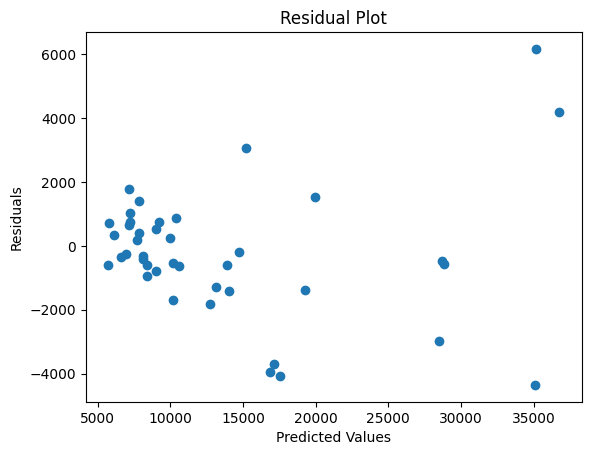

        Actual     Predicted
15   30760.000  35112.864043
9    17859.167  19247.633435
100   9549.000   9020.548817
132  11850.000  13140.935742
68   28248.000  28829.181467
95    7799.000   7138.189066
159   7788.000   8116.621856
162   9258.000   7845.211049
147  10198.000   9949.784613
182   7775.000   8388.758263


In [15]:
# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Show predictions (first 10)
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df.head(10))

## Conclusion

This notebook demonstrates a basic car price prediction model. Further improvements can be achieved by:

*   Trying different models (e.g., XGBoost, LightGBM).
*   Performing more extensive feature engineering.
*   Collecting more data.
*   Fine-tuning hyperparameters more thoroughly.